In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Environment with abrupt change, pre-generate means and noise
class AbruptChangeBandit:
    def __init__(self, k=10, change_time=501, rng=None):
        self.k = k
        self.change_time = change_time
        self.rng = rng or np.random.default_rng()
    
    def generate_run(self, time_steps):
        
        initial_means = self.rng.normal(0, 1, size=self.k)
        permutation = self.rng.permutation(self.k)
        means_over_time = np.zeros((time_steps, self.k))
        means = initial_means.copy()
        for t in range(time_steps):
            # At the change_time, permute means
            if (t + 1) == self.change_time:
                means = means[permutation]
            means_over_time[t] = means
        # Pre-generate reward noise (standard normal)
        noise = self.rng.normal(0, 1, size=(time_steps, self.k))
        return initial_means, means_over_time, noise

In [15]:
# Base Agent
class BaseAgent:
    def __init__(self, k, rng=None):
        self.k = k
        self.rng = rng or np.random.default_rng()
    def select_action(self):
        raise NotImplementedError
    def update(self, action, reward):
        raise NotImplementedError
    def reset(self, *args, **kwargs):
        raise NotImplementedError



In [16]:
# Greedy agent (sample-average updates)
class GreedyAgent(BaseAgent):
    def __init__(self, k, rng=None):
        super().__init__(k, rng)
    def reset(self, initial_means=None):
        self.q_values = np.zeros(self.k)
        self.counts = np.zeros(self.k, dtype=int)
    def select_action(self):
        max_q = np.max(self.q_values)
        candidates = np.where(self.q_values == max_q)[0]
        return int(self.rng.choice(candidates))
    def update(self, action, reward):
        self.counts[action] += 1
        self.q_values[action] += (reward - self.q_values[action]) / self.counts[action]

In [17]:
# Epsilon-Greedy agent (constant step-size updates)
class EpsilonGreedyAgent(BaseAgent):
    def __init__(self, k, epsilon=0.1, alpha=0.1, rng=None):
        super().__init__(k, rng)
        self.epsilon = epsilon
        self.alpha = alpha
    def reset(self, initial_means=None):
        self.q_values = np.zeros(self.k)
    def select_action(self):
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(self.k))
        else:
            max_q = np.max(self.q_values)
            candidates = np.where(self.q_values == max_q)[0]
            return int(self.rng.choice(candidates))
    def update(self, action, reward):
        self.q_values[action] += self.alpha * (reward - self.q_values[action])

In [18]:
# Optimistic initial-values greedy agent (sample-average updates)
class OptimisticGreedyAgent(BaseAgent):
    def __init__(self, k, z_value=2.575, rng=None):
        super().__init__(k, rng)
        self.z_value = z_value
    def reset(self, initial_means):
        mu_max = np.max(initial_means)
        optimistic_init = mu_max + self.z_value * 1.0
        self.q_values = np.full(self.k, optimistic_init, dtype=float)
        self.counts = np.zeros(self.k, dtype=int)
    def select_action(self):
        max_q = np.max(self.q_values)
        candidates = np.where(self.q_values == max_q)[0]
        return int(self.rng.choice(candidates))
    def update(self, action, reward):
        self.counts[action] += 1
        self.q_values[action] += (reward - self.q_values[action]) / self.counts[action]

In [19]:
# Gradient bandit agent with baseline
class GradientBanditAgent(BaseAgent):
    def __init__(self, k, alpha=0.1, use_baseline=True, rng=None):
        super().__init__(k, rng)
        self.alpha = alpha
        self.use_baseline = use_baseline
    def reset(self, initial_means=None):
        self.preferences = np.zeros(self.k)
        self.avg_reward = 0.0
        self.time = 0
    def select_action(self):
        max_pref = np.max(self.preferences)
        exp_p = np.exp(self.preferences - max_pref)
        probs = exp_p / np.sum(exp_p)
        return int(self.rng.choice(self.k, p=probs))
    def update(self, action, reward):
        self.time += 1
        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.time
            baseline = self.avg_reward
        else:
            baseline = 0.0
        max_pref = np.max(self.preferences)
        exp_p = np.exp(self.preferences - max_pref)
        probs = exp_p / np.sum(exp_p)
        for i in range(self.k):
            if i == action:
                self.preferences[i] += self.alpha * (reward - baseline) * (1 - probs[i])
            else:
                self.preferences[i] -= self.alpha * (reward - baseline) * probs[i]

In [20]:
# Run abrupt-change experiments for specified agents
def run_abrupt_experiment(agent_builders, num_sims=1000, time_steps=2000,
                         change_time=501, master_seed=12345, reset=False):
    k = 10
    sum_rewards = {name: np.zeros(time_steps) for name in agent_builders}
    sum_opt = {name: np.zeros(time_steps) for name in agent_builders}
    for sim in range(num_sims):
        rng_env = np.random.default_rng(master_seed + sim)
        env = AbruptChangeBandit(k=k, change_time=change_time, rng=rng_env)
        initial_means, means_over_time, noise = env.generate_run(time_steps)
        agents = {}
        for idx, (name, builder) in enumerate(agent_builders.items()):
            rng_agent = np.random.default_rng(master_seed + 10000 * (idx + 1) + sim)
            agent = builder(rng_agent)
            try:
                agent.reset(initial_means)
            except TypeError:
                agent.reset(None)
            agents[name] = agent
        for t in range(time_steps):
            current_means = means_over_time[t]
            optimal = int(np.argmax(current_means))
            if reset and (t + 1) == change_time:
                for name, agent in agents.items():
                    try:
                        agent.reset(means_over_time[t])
                    except TypeError:
                        agent.reset(None)
            for name, agent in agents.items():
                action = agent.select_action()
                reward = current_means[action] + noise[t, action]
                agent.update(action, reward)
                sum_rewards[name][t] += reward
                if action == optimal:
                    sum_opt[name][t] += 1
    results = {}
    for name in agent_builders:
        avg_r = sum_rewards[name] / num_sims
        avg_opt_pct = (sum_opt[name] / num_sims) * 100.0
        results[name] = (avg_r, avg_opt_pct)
    return results


In [21]:
# Builder functions for agents
def build_greedy(rng):
    return GreedyAgent(k=10, rng=rng)
def build_epsilon(rng, epsilon=0.1, alpha=0.1):
    return EpsilonGreedyAgent(k=10, epsilon=epsilon, alpha=alpha, rng=rng)
def build_optimistic(rng):
    return OptimisticGreedyAgent(k=10, z_value=2.575, rng=rng)
def build_gradient(rng, alpha=0.1):
    return GradientBanditAgent(k=10, alpha=alpha, use_baseline=True, rng=rng)

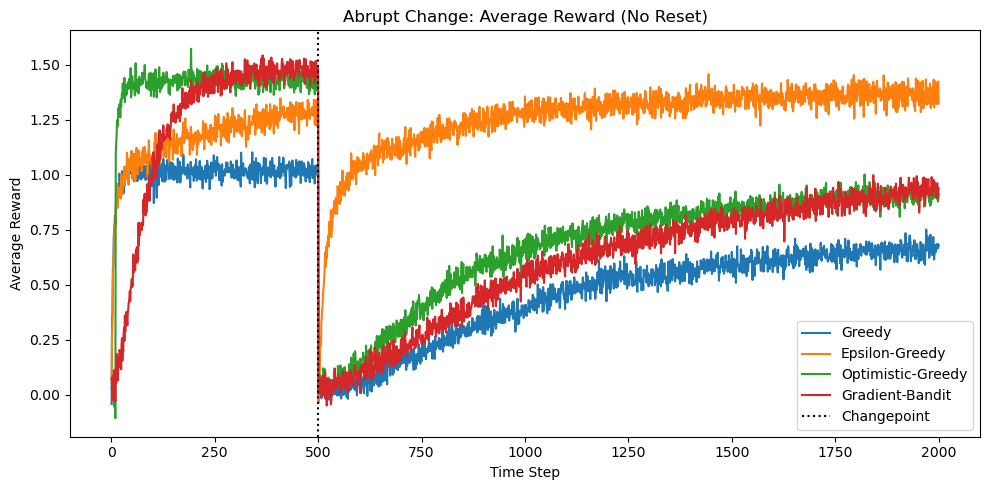

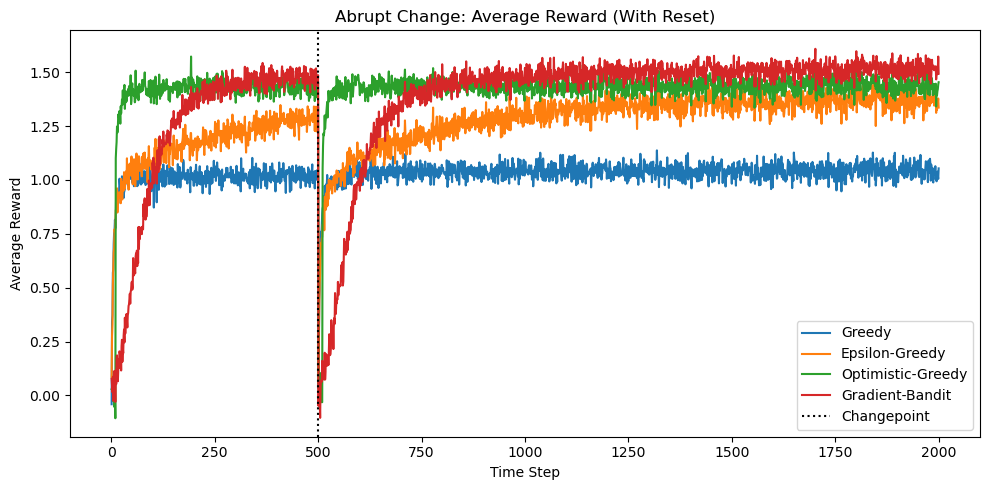

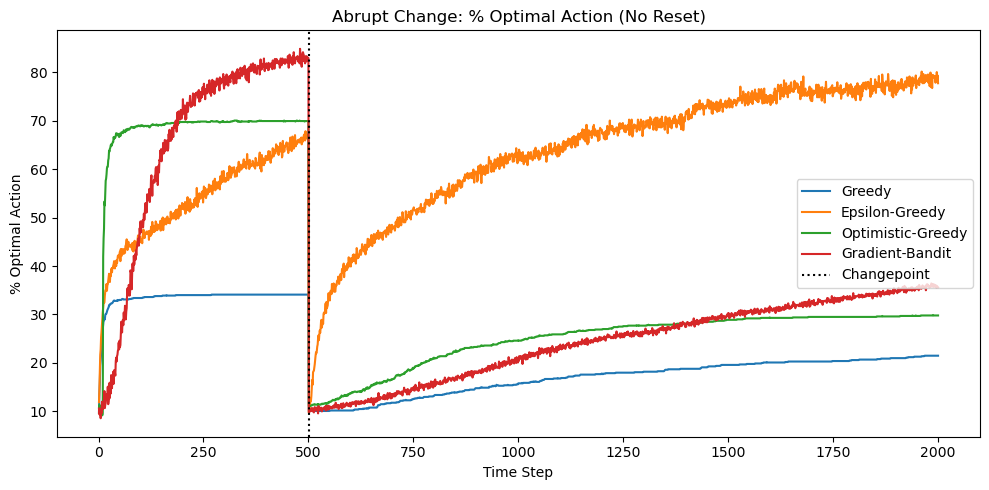

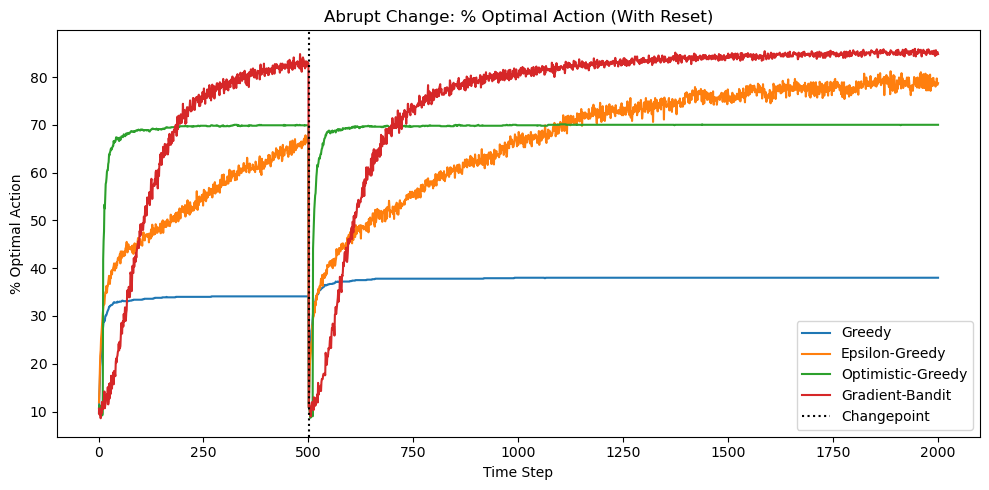

In [22]:
# Main execution: two figures for non-reset and reset, each showing all 4 algorithms
if __name__ == '__main__':
    num_sims = 1000   # use 1000 for final experiments
    time_steps = 2000
    change_time = 501
    master_seed = 12345
    epsilon = 0.1
    alpha = 0.1

    agent_builders = {
        'Greedy': lambda rng: build_greedy(rng),
        'Epsilon-Greedy': lambda rng: build_epsilon(rng, epsilon=epsilon, alpha=alpha),
        'Optimistic-Greedy': lambda rng: build_optimistic(rng),
        'Gradient-Bandit': lambda rng: build_gradient(rng, alpha=alpha)
    }

    # Run experiments
    results_no_reset = run_abrupt_experiment(
        agent_builders, num_sims=num_sims,
        time_steps=time_steps, change_time=change_time,
        master_seed=master_seed, reset=False
    )
    results_reset = run_abrupt_experiment(
        agent_builders, num_sims=num_sims,
        time_steps=time_steps, change_time=change_time,
        master_seed=master_seed, reset=True
    )


    x = np.arange(1, time_steps + 1)

    # Figure 1: Non-reset, average reward for all 4 algorithms
    plt.figure(figsize=(10, 5))
    for name, (avg_r_no, _) in results_no_reset.items():
        plt.plot(x, avg_r_no, label=name)
    plt.axvline(x=change_time, color='k', linestyle=':', label='Changepoint')
    plt.xlabel('Time Step')
    plt.ylabel('Average Reward')
    plt.title('Abrupt Change: Average Reward (No Reset)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 2: Reset, average reward for all 4 algorithms
    plt.figure(figsize=(10, 5))
    for name, (avg_r_res, _) in results_reset.items():
        plt.plot(x, avg_r_res, label=name)
    plt.axvline(x=change_time, color='k', linestyle=':', label='Changepoint')
    plt.xlabel('Time Step')
    plt.ylabel('Average Reward')
    plt.title('Abrupt Change: Average Reward (With Reset)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: also plot % optimal action similarly
    # Figure 3: Non-reset, % optimal action for all 4 algorithms
    plt.figure(figsize=(10, 5))
    for name, (_, avg_opt_no) in results_no_reset.items():
        plt.plot(x, avg_opt_no, label=name)
    plt.axvline(x=change_time, color='k', linestyle=':', label='Changepoint')
    plt.xlabel('Time Step')
    plt.ylabel('% Optimal Action')
    plt.title('Abrupt Change: % Optimal Action (No Reset)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 4: Reset, % optimal action for all 4 algorithms
    plt.figure(figsize=(10, 5))
    for name, (_, avg_opt_res) in results_reset.items():
        plt.plot(x, avg_opt_res, label=name)
    plt.axvline(x=change_time, color='k', linestyle=':', label='Changepoint')
    plt.xlabel('Time Step')
    plt.ylabel('% Optimal Action')
    plt.title('Abrupt Change: % Optimal Action (With Reset)')
    plt.legend()
    plt.tight_layout()
    plt.show()
